In [13]:
import tensorflow as tf
import tensorflow_datasets as tfds
tfds.disable_progress_bar()

import numpy as np
import matplotlib.pyplot as plt

import importlib
import utils.ml_utils as ml_utils

from tensorflow.keras import layers
from tensorflow import keras

from tensorflow.keras.applications.nasnet import NASNetMobile

In [2]:
# Constants to be used throughout the file
SHUFFLE_SEED = 524287 # Seed for shuffling

IMG_SIZE = 200 # All images in the dataset will be resized to this size

BATCH_SIZE = 32 # Batch size
SHUFFLE_BUFFER_SIZE = 1000 # Buffer size for shuffling

In [3]:
# Read training data
(raw_train, raw_validation, raw_test), label_names = ml_utils.load_dataset('cats_vs_dogs')

Shuffling and writing examples to /home/darylchang/tensorflow_datasets/cats_vs_dogs/4.0.0.incompleteOYRF8C/cats_vs_dogs-train.tfrecord
Dataset cats_vs_dogs downloaded and prepared to /home/darylchang/tensorflow_datasets/cats_vs_dogs/4.0.0. Subsequent calls will reuse this data.
Training Data Summary
No. of examples: 18610
Class: 0 :::: Count: 9378 :::: Percentage: 50.39226222461043
Class: 1 :::: Count: 9232 :::: Percentage: 49.60773777538957

Validation Data Summary
No. of examples: 2326
Class: 0 :::: Count: 1120 :::: Percentage: 48.15133276010318
Class: 1 :::: Count: 1206 :::: Percentage: 51.84866723989682

Test Data Summary
No. of examples: 2326
Class: 0 :::: Count: 1160 :::: Percentage: 49.871023215821154
Class: 1 :::: Count: 1166 :::: Percentage: 50.128976784178846


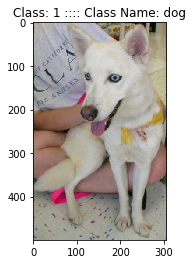

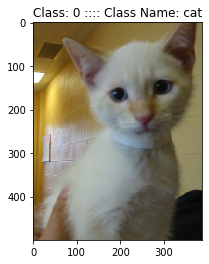

In [4]:
# Print some images
for img, lbl in raw_train.take(2):
    ml_utils.show_image(img, lbl, label_names)

In [5]:
# Resize images to IMG_SIZE x IMG_SIZE
train = raw_train.map(lambda img, lbl: ml_utils.resize_image(img, lbl, IMG_SIZE))
validation = raw_validation.map(lambda img, lbl: ml_utils.resize_image(img, lbl, IMG_SIZE))
test = raw_test.map(lambda img, lbl: ml_utils.resize_image(img, lbl, IMG_SIZE))

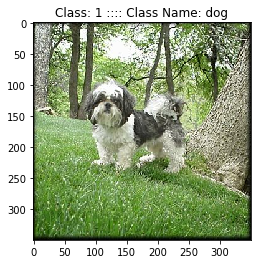

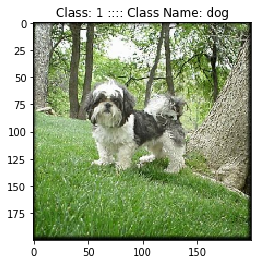

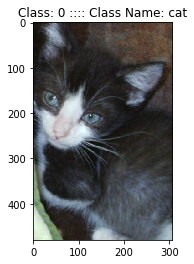

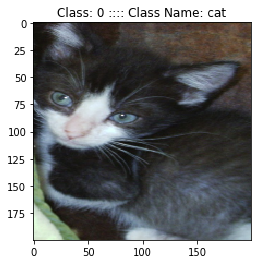

In [6]:
# Compare original and resized images
for img, lbl in raw_train.take(2):
    # Original image
    ml_utils.show_image(img, lbl, label_names)
  
    # Resized image
    reszd_img, _ = ml_utils.resize_image(img, lbl, IMG_SIZE)
    ml_utils.show_image(reszd_img, lbl, label_names)

In [7]:
# Diving data into batches
train_batches = train.shuffle(
    buffer_size=SHUFFLE_BUFFER_SIZE,
    seed=SHUFFLE_SEED
).batch(BATCH_SIZE)
validation_batches = validation.batch(BATCH_SIZE)
test_batches = test.batch(BATCH_SIZE)

In [26]:
# Simple convnet model
def simple_convnet_model():
    model = keras.models.Sequential()
    input_tensor = layers.Input((IMG_SIZE, IMG_SIZE, 3))
    model.add(input_tensor)
    model.add(NASNetMobile(include_top=False, input_tensor=input_tensor))
    model.add(layers.Flatten())
    model.add(layers.Dense(32, activation='relu'))
    model.add(layers.Dense(1, activation='sigmoid'))
    return model

In [27]:
# Build model
model=simple_convnet_model()
model.summary()

Model: "sequential_7"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
NASNet (Model)               (None, 7, 7, 1056)        4269716   
_________________________________________________________________
flatten_2 (Flatten)          (None, 51744)             0         
_________________________________________________________________
dense_2 (Dense)              (None, 32)                1655840   
_________________________________________________________________
dense_3 (Dense)              (None, 1)                 33        
Total params: 5,925,589
Trainable params: 5,888,851
Non-trainable params: 36,738
_________________________________________________________________


In [29]:
# Compile model
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

In [30]:
# Start training
history = model.fit(
    train_batches,
    epochs=10,
    validation_data=validation_batches
)

Epoch 1/10
     70/Unknown - 1090s 16s/step - loss: 0.7581 - accuracy: 0.8374

KeyboardInterrupt: 

In [ ]:
# Plot diagnostic learning curves
ml_utils.summarize_diagnostics(history)

In [ ]:
# Print test loss and accuracy
loss, accuracy = model.evaluate(test_batches)
print('\nTest Data :::: Loss: {loss} :::: Accuracy: {accuracy}'.format(
    loss=loss,
    accuracy=accuracy)
)